This notebook is meant for applying the final extinction corrections and photometry normalization to a flux-calibrated spectrum. The code below is a collections of routines from various individuals, so any adjustments to boost cohesion or overall ease of use are appreciated!

-Armaan Goyal

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)

def data_from_text(filename):
    data = np.genfromtxt(filename, usecols = (0, 1))
    wav, flux = np.split(data, 2, axis = 1)
    flux = np.reshape(flux, len(flux))
    wav = np.reshape(wav, len(wav))
    return wav, flux

Below is code written by Wen-fai Fong (adapted from Matlab) for converting photometric data to flux density data for plotting and comparison with the spectrum. The g, r, i, and z SDSS photometric bands are considered due to their overlap with typical MODS optical spectra, but feel free to add more bands as needed. Input the photometric band wavelength centers (in angstroms) below with your data and errors. If you need to correct for extinction in your photometric data, input your object RA and Dec into the following calculator (http://ned.ipac.caltech.edu/forms/calculator.html) and subtract the corresponding band extinction values from your photometric data.

In [3]:
#photmetric conversions

def flamconvert(wl,mag):
#wavelength in Ang and fluxes in erg/s/cm2/Ang
    flam = 10**((mag+5*np.log10(wl)+2.406)/(-2.5))
    return flam

def flam_err(wl, mag, mag_err):
    errors = []
    mag_hi = mag + mag_err
    mag_lo = mag - mag_err
    flam_lo = flamconvert(wl, mag_hi)
    flam_hi = flamconvert(wl, mag_lo)
    center = flamconvert(wl, mag)
    lo, hi = (np.abs(center - flam_lo), np.abs(center - flam_hi))
    return np.stack((lo, hi))

#griz photometric band wavelength centers in angstroms
wl = np.array([4760, 6156, 7472, 8917])

#sample griz photometric data w/errors
mag = np.array([23.098, 21.952, 21.523, 21.651])
mag_err = np.array([.118, .052, .050, .089])

flams = flamconvert(wl, mag)
flam_errs = flam_err(mag, wl, mag_err)

The following routines were written by Kerry Paterson, and they define and automatically apply extinction corrections to a flux-calibrated spectrum. You will need the redshift of the spectrum as well as the $A_{V}$ for the relevant observational sightline, which you can find at http://ned.ipac.caltech.edu/forms/calculator.html. You will find that the output spectrum may include fewer points than the input - this is due to the fact that any points with negative flux values will be discarded to avoid the presence of NaNs in the final spectrum.

In [ ]:
#define UV, optical, and IR extinction corrections

def uv_extinction(w):
    Rv=3.1
    x=1/w 
    Fax=-0.04473*(x-5.9)**2-0.009779*(x-5.9)**3
    Fbx=0.2130*(x-5.9)**2+0.1207*(x-5.9)**3
    A = []
    if x<=1/5.9:
        a=1.752-0.316*x-0.104/((x-4.67)**2+0.341)+Fax
        b=-3.090+1.825*x+1.206/((x-4.62)**2+0.263)+Fbx
    else:
        a=1.752-0.316*x-0.104/((x-4.67)**2+0.341)
        b=-3.090+1.825*x+1.206/((x-4.62)**2+0.263)
    return a+b/Rv

def opt_extinction(w):
    Rv=3.1
    y=1/w-1.82
    a=1+0.17699*y-0.50447*y**2-0.02427*y**3+0.72085*y**4+0.01979*y**5-0.77530*y**6+0.32999*y**7
    b=1.41338*y+2.28305*y**2+1.07233*y**3-5.38434*y**4-0.62251*y**5+5.30260*y**6-2.09002*y**7
    return a+b/Rv

def nir_extinction(w):
    Rv=3.1
    x=1/w
    a=0.574*x**1.61
    b=-0.527*x**1.61
    return a+b/Rv

In [ ]:
def extinction_corr(AV, z, data, **kwargs):
    save = kwargs.get("save", False)
    error = kwargs.get("error", None)
    wav, flux = data_from_text(data)
    flux_corr = []
    wav_rest = wav/1e4/(1+z)
    for i in range(len(wav_rest)):
        if wav_rest[i]<=0.303:
            A = uv_extinction(wav_rest[i])
        elif wav_rest[i]>0.303 and wav_rest[i]<=0.91:
            A = opt_extinction(wav_rest[i])
        else:
            A = nir_extinction(wav_rest[i])
        mag = -2.5*np.log10(flux[i])
        magcorr = mag - A*AV
        fcorr = 10**(-0.4*magcorr)
        flux_corr.append(fcorr)
    flux_arr = np.array(flux_corr)
    not_nans = ~np.isnan(flux_arr)
    wav = wav[not_nans]
    flux_arr = flux_arr[not_nans]
    if error:
        error_arr = data_from_text(error)[1]
        error_arr = error_arr[not_nans]
    if save:
        output = np.column_stack((wav, flux_arr))
        out_name = data.split(".")[0] + "_ext"
        np.savetxt(out_name, output)
        if error:
            err_out = np.column_stack((wav, error_arr))
            err_name = error.split(".")[0] + "_ext"
            np.savetxt(err_name, err_out)
    return flux_arr

flux_ext = extinction_corr(.14, .4535, "sgrb101224a.dat", error = "sky_err.txt", save = False)

The code below is for plotting the spectroscopic and photometric data with the error spectrum and S/N. To determine the photometric correction, plot the photometric and extinction-corrected spectroscopic data yielded by the tasks before and inspect for offsets between them. If the spectral contiuum does not seem to align with the photometric points, multiply the flux data by a constant and continue to adjust until general agreement. The cell below this plotting code allows you to renormalize the object and error spectra by this factor, generating two new files that can then be fed back into the plotting code for a final visualization of the data.

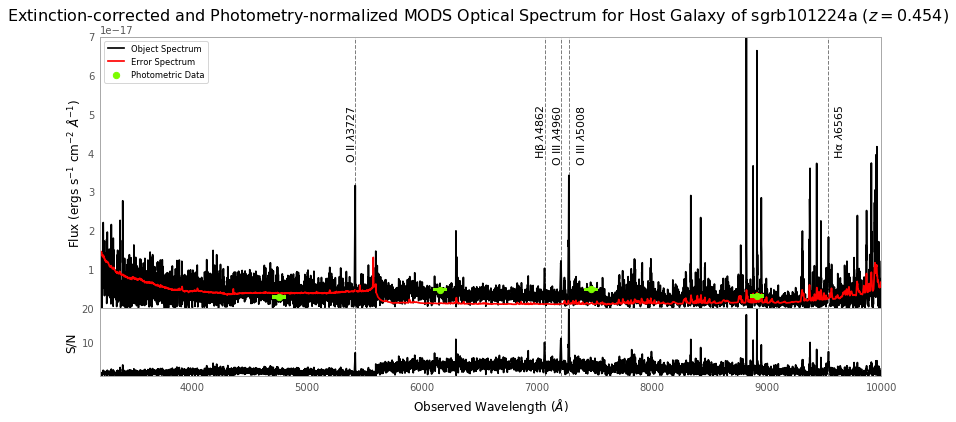

In [13]:
#load object and error spectra
wav, flux_ext = data_from_text("sgrb101224a_ext_norm")
wav_err, err = data_from_text("sky_err_ext")

#title
title = "Extinction-corrected and Photometry-normalized MODS Optical Spectrum for Host Galaxy of sgrb101224a"
redshift = .454

#plot limits
wav_lim = (3200, 10000)
flux_lim = (0, .7e-16)
SN_lim = (0, 20)

#observed line list with corresponding line names and rest-frame wavelengths (in order!)
line_list = [5419.57, 7067.71, 7209.96]
line_labels = ['O II', 'Hβ', 'O III']
rest_list = [3727.092, 4862.68, 4960.295]

#height of name placement for lines
name_height = 5*10**(-17)

#photometric wavelenght bins, data, and errors
wl = wl
flams = flams
flam_errs = flam_errs

#test photometric normalization
photo_norm = 1
flux_ext *= photo_norm
err *= photo_norm

#output name if image of plot is to be saved
save_name = "sgrb101224a_mods_plot"

#plotting code
fig, ax = plt.subplots(nrows=2, sharex = True, squeeze = True, figsize=(14,6), gridspec_kw={'height_ratios': [4, 1]})
plt.suptitle(title + " ($z = %.3f$)"%redshift, size = 16)
ax[1].set_xlabel("Observed Wavelength ($\AA$)")
ax[1].set_ylabel("S/N")
ax[0].set_ylabel("Flux (ergs s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)")
ax[0].plot(wav, flux_ext, c = "black", label = "Object Spectrum")
ax[0].plot(wav, err, label = "Error Spectrum", c = "red")

#photometric 
ax[0].scatter(wl, flams, color = "lawngreen", s = 40, zorder = 10, label = "Photometric Data")
ax[0].errorbar(wl, flams, yerr=flam_errs, fmt = "none", ecolor="lawngreen", capsize = 7, capthick=2)

ax[0].legend(fontsize = "small")
ax[1].plot(wav, flux_ext/err, label = "Red", c = "black")
#ax[1].plot(wav, flux_ext/errb_y, label = "Blue", c = "black")
ax[0].set_xlim(wav_lim[0], wav_lim[1])
ax[0].set_ylim(flux_lim[0], flux_lim[1])
ax[1].set_ylim(SN_lim[0], SN_lim[1])
plt.subplots_adjust(hspace=.0)

for i in range(len(line_list)):
    ax[0].axvline(line_list[i], color = "black", ls = "--", lw = 1, alpha = .5)
    ax[1].axvline(line_list[i], color = "black", ls = "--", lw = 1, alpha = .5)
    ax[0].text(line_list[i]-90, name_height, "%s $\lambda %d$"%(line_labels[i], int(rest_list[i])), size = 11, rotation="vertical")

#code for adding lines manually if you need to separately adjust heights/name placements
#comment this out if you are fine with the automatic line displays
ax[0].axvline(7279.55, color = "black", ls = "--", lw = 1, alpha = .5)
ax[1].axvline(7279.55, color = "black", ls = "--", lw = 1, alpha = .5)
ax[0].text(7279.55+50, name_height, "O III $\lambda$5008", size = 11, rotation="vertical")

ax[0].axvline(9538.86, color = "black", ls = "--", lw = 1, alpha = .5)
ax[1].axvline(9538.86, color = "black", ls = "--", lw = 1, alpha = .5)
ax[0].text(9540+35, name_height, "Hα $\lambda$6565", size = 11, rotation="vertical")

ax[0].grid(False)
ax[0].grid(False)
ax[1].grid(False)
fig.subplots_adjust(top=.91)
for a in ax:
        labels = a.yaxis.get_major_ticks()
        labels[0].label1.set_visible(False)
plt.show()

#save image of plot, comment out if not needed
#fig.savefig(save_name)

In [6]:
def error_renorm(error, num_exp):
    wav, flux = data_from_text(error)
    output = np.column_stack((wav, flux/np.sqrt(num_exp)))
    name = error.split(".")[0] + "_norm"
    np.savetxt(name, output)
    
def data_renorm(data, N):
    wav, flux = data_from_text(data)
    output = np.column_stack((wav, flux*N))
    name = data.split(".")[0] + "_norm"
    np.savetxt(name, output)

This final cell is meant to combine the object and error spectra into a single, three-column text file. This step is entirely optional, but provides a convenient means of storing all the data together, which may come in handy for further analysis (especially in Prospector).

In [12]:
def three_column(data, error, save_name):
    wav, flux = data_from_text(data)
    wav, err = data_from_text(error)
    output = np.column_stack((wav, flux, err))
    np.savetxt(save_name, output)

You're all done - congratulations on performing a full analysis of a spectroscopic dataset! Be sure to save your pretty plot and store all of your files in a safe place!